In [ ]:
COLAB = False

In [137]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

if COLAB:
    SRC_PATH = os.path.abspath(os.path.join('../..'))
    sys.path.append(SRC_PATH)

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from prflwr.utils.pytorch import set_seed
from torch.utils.data import DataLoader

from importlib import reload
import utils
reload(utils)
from utils import load_data, test, train, resnet20

SEED = 0
BATCH_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)
print("numpy", np.__version__)
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print(f"Training on {DEVICE}")


numpy 1.20.3
torch 1.11.0
torchvision 0.12.0
Training on cuda


In [138]:
# Load data
trainset, testset = load_data("../.." if not COLAB else ".")
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


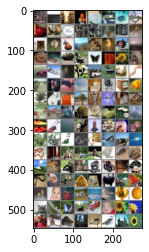

crocodile - keyboard - cattle - orange - plate - house -   ray - bicycle - 
apple - beaver - clock - raccoon - pine_tree - tiger - telephone - spider - 
telephone - possum -  pear - mountain - squirrel -  lion -   man - plain - 
clock -   ray -  tank - skunk - butterfly - wardrobe - sunflower - porcupine - 



In [139]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

images, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(images))
print(''.join('%5s - ' % trainset.classes[labels[j]].replace(" ", "") + ("\n" if (j + 1) % 8 == 0 else "") for j in range(32)))

In [140]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [141]:
# Load model
model = resnet20(num_classes=100, option="B")
print("Number of parameters:", count_parameters(model))

Number of parameters: 275572


In [142]:
EPOCHS = 164
MILESTONES = [81, 122]
criterion = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
train_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.1)  # learning rate decay

In [143]:
# Check initial evaluation metrics
loss, accuracy = test(model, testloader, device=DEVICE)
print(f"Initial test set performance: loss {loss}, accuracy {accuracy}")

RuntimeError: The size of tensor a (16) must match the size of tensor b (32) at non-singleton dimension 3

In [78]:
# Start centralized training
hist = {"train_loss" : [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []}
for epoch in range(EPOCHS):
    train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, DEVICE)
    test_loss, test_accuracy = test(model, testloader, DEVICE)
    train_scheduler.step(epoch)
    hist["train_loss"].append(train_loss)
    hist["train_accuracy"].append(train_accuracy)
    hist["test_loss"].append(test_loss)
    hist["test_accuracy"].append(test_accuracy)
    print(f"Epoch {epoch+1}: test loss {loss}, accuracy {accuracy}, learning rate {optimizer.param_groups[0]['lr']}")

KeyboardInterrupt: 

In [ ]:
# Evaluate performances on testset
loss, accuracy = test(model, testloader, device=DEVICE)
print(f"Final test set performance: loss {loss}, accuracy {accuracy}")

Final test set performance: loss 4.003739193725586, accuracy 0.078
